In [2]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
import numpy as np
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, GlobalAveragePooling2D, Dense, BatchNormalization, Activation, Add, Dropout, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


Load Data

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0],True)

data = []
labels = []
dataset_path = '../Vegetable'
classes = os.listdir(dataset_path)
img_rows, img_cols = 40,40


for class_id, class_name in enumerate(classes):
    folder_path = os.path.join(dataset_path, class_name)
    image_files = os.listdir(folder_path)
    print(class_id)
    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        img = image.load_img(image_path,target_size=(img_rows, img_cols,3),color_mode='rgb')
        img_array = image.img_to_array(img)
        data.append(img_array)
        labels.append(class_id)


X = np.array(data)
Y = np.array(labels)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [4]:
x_train, x_temp, y_train, y_temp = train_test_split(X,Y, test_size=0.2, random_state=int(time.time()))
x_test,x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=int(time.time()))

Preprocessing

In [5]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3).astype('float32')/255.0
x_val = x_val.reshape(x_val.shape[0], img_rows, img_cols, 3).astype('float32')/255.0

In [6]:
#one hot encoding
y_train = tf.keras.utils.to_categorical(y_train, len(classes))
y_test = tf.keras.utils.to_categorical(y_test, len(classes))
y_val = tf.keras.utils.to_categorical(y_val, len(classes))

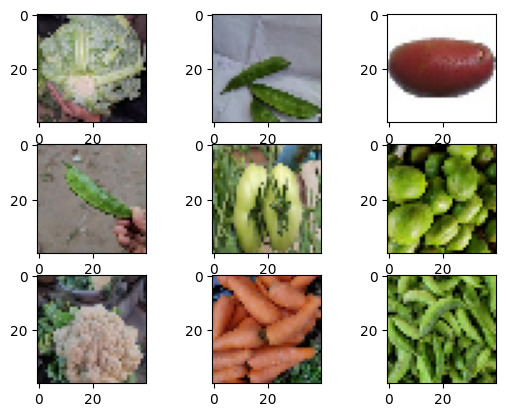

In [7]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i], cmap='gray')

plt.show()

In [12]:
def inception_module(x, filters):
    conv1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    
    conv3 = Conv2D(filters[1], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv3)

    conv5 = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(x)
    conv5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(conv5)

    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(filters[3], (1, 1), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(pool)

    x = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return x

def create_google_net(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    x = Conv2D(32, (7, 7), padding='same', activation='relu', kernel_regularizer=l2(0.0001))(input_layer)
    x = BatchNormalization()(x)

    x = inception_module(x, [32, 64, 64, 128, 64,32])
    x = inception_module(x, [32, 64, 64, 128, 64,32])
    x = inception_module(x, [64, 128, 128, 256, 128,64])
    
    x = inception_module(x, [64, 128, 128, 256, 128,64])
    x = Dropout(0.3)(x)

    
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    
    return model



In [20]:
model = create_google_net(input_shape=(img_cols,img_rows,3), num_classes=len(classes))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_50 (Conv2D)             (None, 40, 40, 32)   4736        ['input_3[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 40, 40, 32)  128         ['conv2d_50[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv2d_52 (Conv2D)             (None, 40, 40, 64)   2112        ['batch_normalization_2[0][

In [21]:
epochs = 20
batch_size=64

early_stop = EarlyStopping(monitor='val_loss', patience=5)

checkpoint = ModelCheckpoint('best_model.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

history = model.fit(
    x_train,y_train,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint,early_stop]
)
score = model.evaluate(x_test,y_test)
print(f"Test score : {score[0]}")
print(f"Test accuraccy : {score[1]}")

Epoch 1/20
525/525 [==============================] - ETA: 0s - loss: 2.0306 - accuracy: 0.5711
Epoch 1: val_loss improved from inf to 1.55587, saving model to best_model.h5
525/525 [==============================] - 88s 162ms/step - loss: 2.0306 - accuracy: 0.5711 - val_loss: 1.5559 - val_accuracy: 0.7262
Epoch 2/20
525/525 [==============================] - ETA: 0s - loss: 1.2494 - accuracy: 0.7977
Epoch 2: val_loss improved from 1.55587 to 1.11622, saving model to best_model.h5
525/525 [==============================] - 86s 164ms/step - loss: 1.2494 - accuracy: 0.7977 - val_loss: 1.1162 - val_accuracy: 0.8429
Epoch 3/20
525/525 [==============================] - ETA: 0s - loss: 1.0343 - accuracy: 0.8649
Epoch 3: val_loss improved from 1.11622 to 0.89775, saving model to best_model.h5
525/525 [==============================] - 84s 160ms/step - loss: 1.0343 - accuracy: 0.8649 - val_loss: 0.8978 - val_accuracy: 0.9033
Epoch 4/20
525/525 [==============================] - ETA: 0s - loss

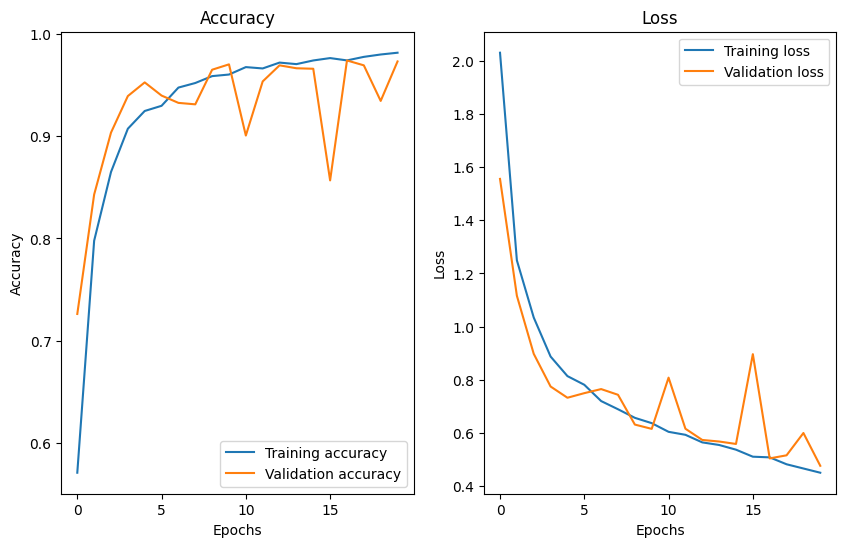

In [22]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('best_model.png')
plt.legend()


In [23]:
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)

66/66 [==============================] - 3s 49ms/step


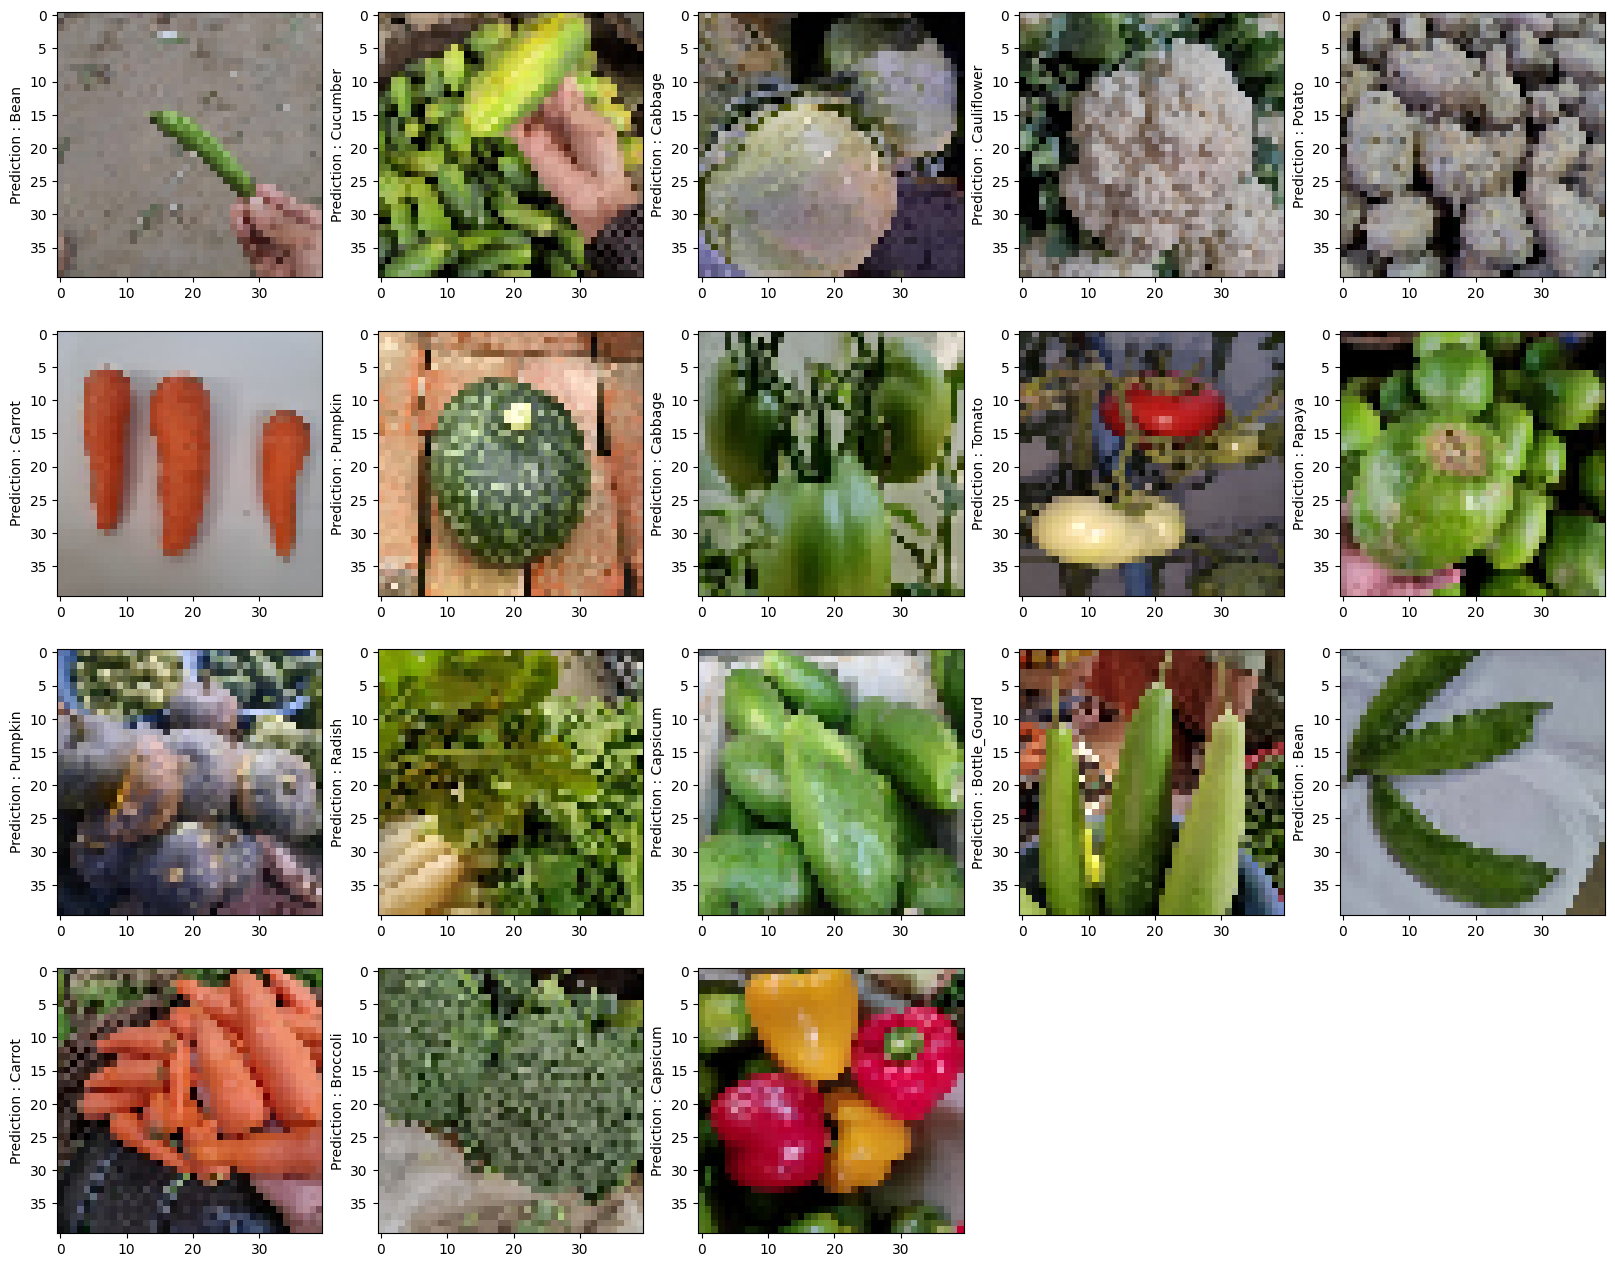

In [24]:
plt.figure(figsize=(20,20))

for i in range(18):
    plt.subplot(5,5,i+1)
    plt.imshow(x_test[i], cmap="gray")
    plt.ylabel(f"Prediction : {classes[predicted_labels[i]]}")

plt.show()